<a href="https://colab.research.google.com/github/ShedovaNastya/Introduction-in-ML/blob/main/5_1dense_and_convolutional_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [ ]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [ ]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

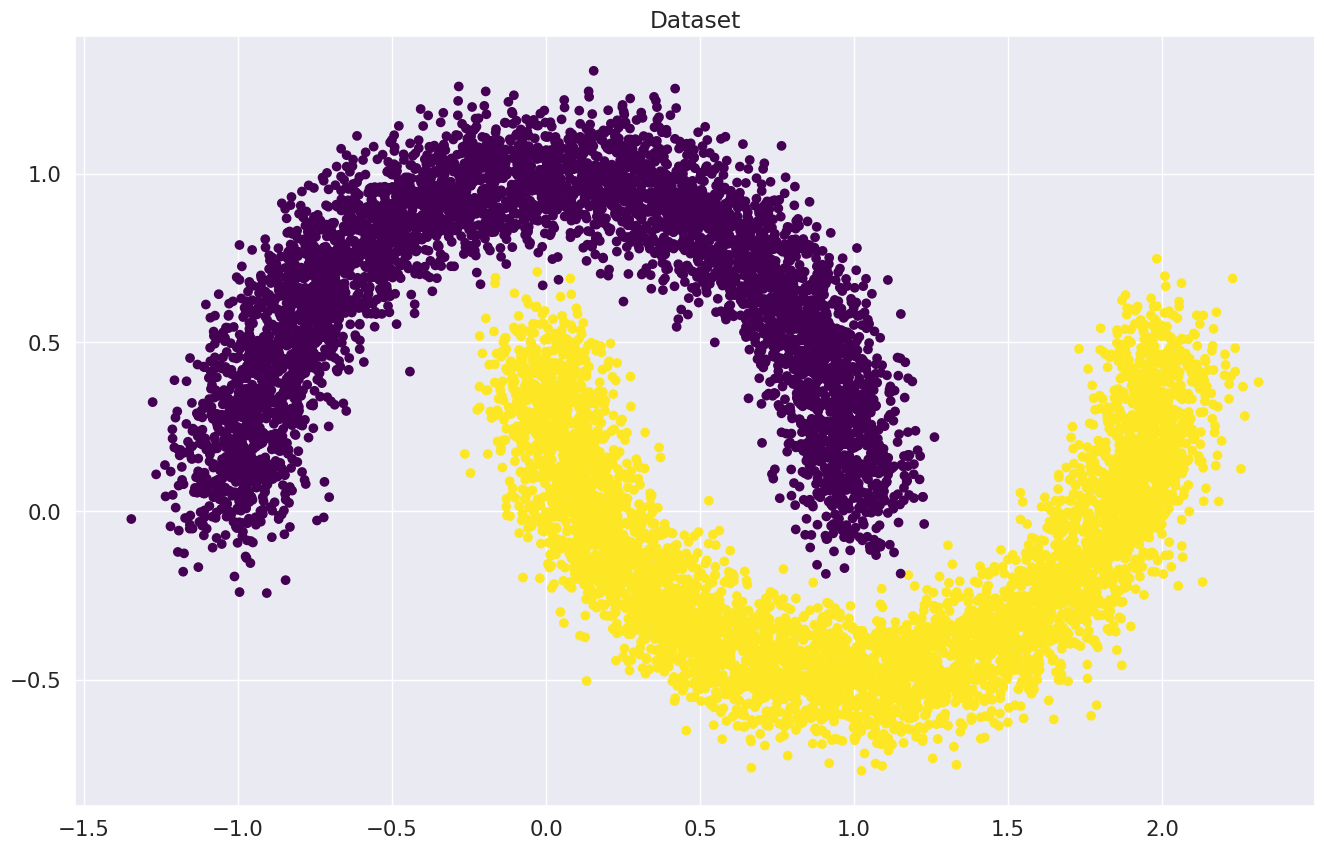

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [ ]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.long)

Создаем `Dataset` и `DataLoader`.

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        # Инициализация весов с нормальным распределением
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            # Инициализация смещения с нормальным распределением, если bias установлен в True
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        # Выполнение линейной трансформации: x * веса
        x = torch.matmul(x, self.weights)
        if self.bias:
            # Добавление смещения, если bias установлен в True
            x += self.bias_term
        return x

In [ ]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [ ]:
total_params = sum(p.numel() for p in linear_regression.parameters())
total_params

3

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# Предположим, что linear_regression, train_dataloader, loss_function, и optimizer уже определены

# Устанавливаем порог для проверки сходимости
tol = 1e-3
# Список для хранения значений потерь
losses = []
# Максимальное количество эпох
max_epochs = 100
# Предыдущие веса модели
prev_weights = torch.zeros_like(linear_regression.weights)
# Флаг для остановки обучения
stop_it = False

# Начинаем обучение
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        # Обнуляем градиенты
        optimizer.zero_grad()
        # Получаем выходные значения модели
        outp = linear_regression(X_batch)
        # Изменяем размер y_batch, чтобы он соответствовал размеру outp
        y_batch = y_batch.view(-1, 1).long()  # Преобразуем y_batch в тип Long
        # Вычисляем потери
        loss = loss_function(outp, y_batch.float())  # Преобразуем y_batch обратно в тип Float для вычисления потерь
        # Вычисляем градиенты
        loss.backward()
        # Сохраняем значение потерь
        losses.append(loss.detach().flatten()[0])
        # Обновляем параметры модели
        optimizer.step()

        # Вычисляем вероятности
        probabilities = torch.sigmoid(outp)
        # Получаем предсказания
        preds = (probabilities > 0.5).type(torch.long)
        # Вычисляем точность на батче
        batch_acc = (preds.flatten() == y_batch.flatten()).type(torch.float32).sum() / y_batch.size(0)

        # Печатаем точность каждые 100 итераций
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Итерация: {it + epoch * len(train_dataloader)}\nТочность на батче: {batch_acc}")

        # Получаем текущие веса модели
        current_weights = linear_regression.weights.detach().clone()
        # Проверяем сходимость
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nИтерация: {it + epoch * len(train_dataloader)}. Сходимость. Останавливаем итерации.")
            stop_it = True
            break
        # Обновляем предыдущие веса
        prev_weights = current_weights

    # Останавливаем обучение, если достигли сходимости
    if stop_it:
        break

Итерация: 0
Точность на батче: 0.515625
Итерация: 100
Точность на батче: 0.671875
Итерация: 200
Точность на батче: 0.7734375
Итерация: 300
Точность на батче: 0.8125
Итерация: 400
Точность на батче: 0.796875
Итерация: 500
Точность на батче: 0.8671875
Итерация: 600
Точность на батче: 0.8515625
Итерация: 700
Точность на батче: 0.796875
Итерация: 800
Точность на батче: 0.8125

Итерация: 877. Сходимость. Останавливаем итерации.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 877

### Визуализируем результаты

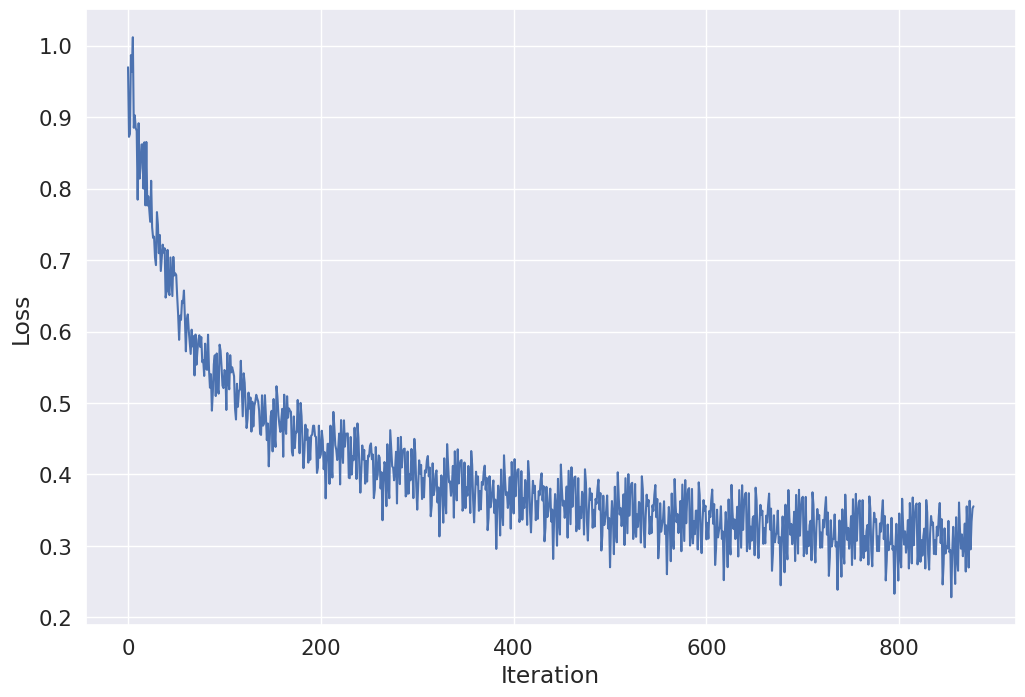

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

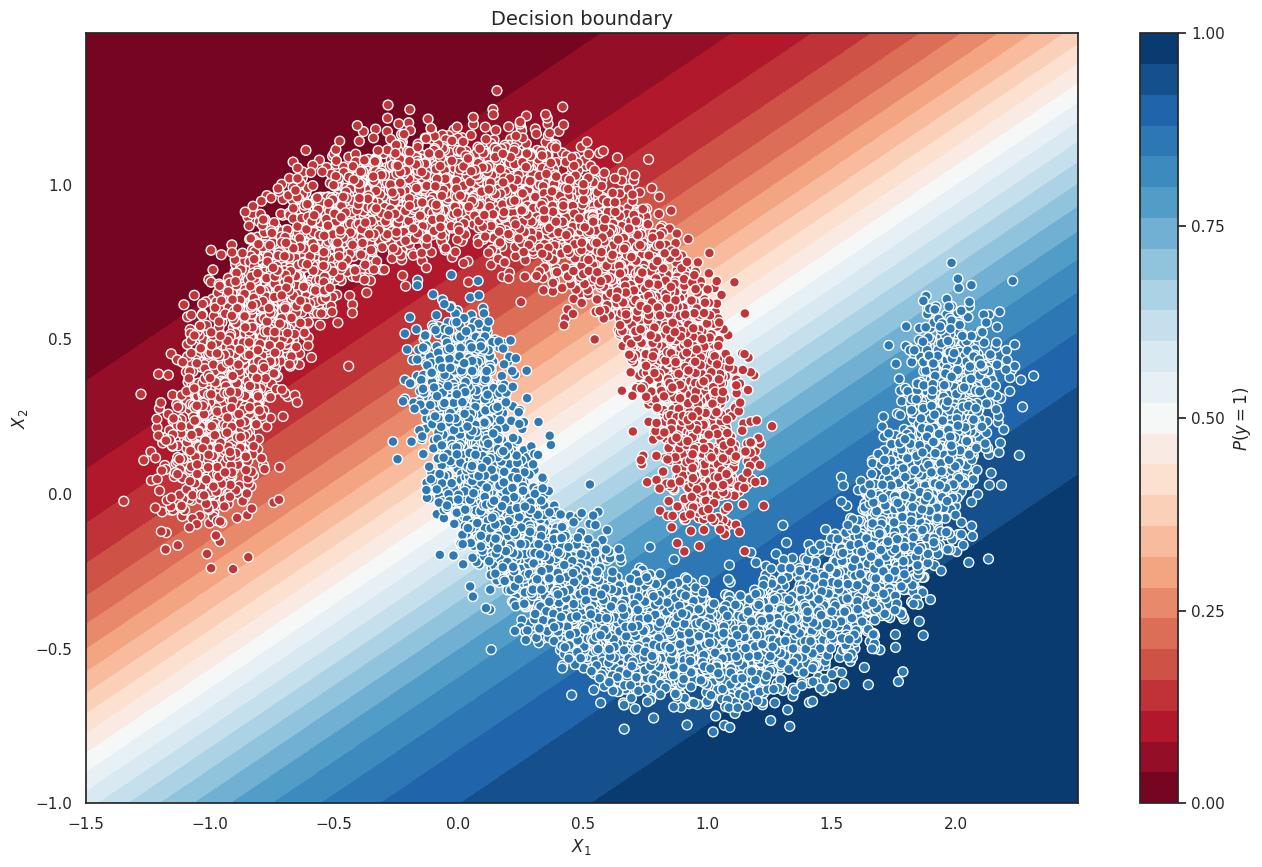

In [ ]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [ ]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()  # Переводим модель в режим оценки
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)  # Получаем выходные значения модели
        preds = (torch.sigmoid(outp) > 0.5).type(torch.long).flatten()  # Вычисляем предсказания
        predictions = np.hstack((predictions, preds.numpy().flatten()))  # Добавляем предсказания в общий массив
    return predictions.flatten()

In [ ]:
from sklearn.metrics import accuracy_score
predictions = predict(val_dataloader, linear_regression)

# Вычисляем точность
accuracy = accuracy_score(y_val, predictions)
print(f'Total Accuracy: {accuracy}')

Total Accuracy: 0.856


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:**0.856

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [ ]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16163087.23it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 490146.13it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4455897.39it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3252608.63it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [ ]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [ ]:

activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

# Define the loss function
loss_function = nn.CrossEntropyLoss()

In [ ]:
import torch.optim as optim
# Определение функции потерь
criterion = nn.CrossEntropyLoss()

# Определение оптимизатора
optimizer = optim.Adam(model.parameters())

# Определение загрузчиков данных
loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()  # Устанавливаем модель в режим обучения
                optimizer.zero_grad()  # Обнуляем градиенты
                outp = model(x_batch)  # Вычисляем выходные значения модели
                loss = criterion(outp, y_batch)  # Вычисляем потери
                loss.backward()  # Вычисляем градиенты
                optimizer.step()  # Обновляем параметры модели
            else:
                model.eval()  # Устанавливаем модель в режим оценки
                with torch.no_grad():  # Отключаем вычисление градиентов
                    outp = model(x_batch)  # Вычисляем выходные значения модели
            preds = outp.argmax(-1)  # Получаем предсказанные метки
            correct = (preds == y_batch).sum()  # Вычисляем количество правильных предсказаний
            all = y_batch.size(0)  # Вычисляем общее количество примеров в батче
            epoch_correct += correct.item()
            epoch_all += all
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.9015666666666666
Loader: valid. Accuracy: 0.9517
Epoch: 2
Loader: train. Accuracy: 0.955
Loader: valid. Accuracy: 0.9618
Epoch: 3
Loader: train. Accuracy: 0.96565
Loader: valid. Accuracy: 0.9678
Epoch: 4
Loader: train. Accuracy: 0.9730833333333333
Loader: valid. Accuracy: 0.969
Epoch: 5
Loader: train. Accuracy: 0.9778166666666667
Loader: valid. Accuracy: 0.9707
Epoch: 6
Loader: train. Accuracy: 0.9788833333333333
Loader: valid. Accuracy: 0.972
Epoch: 7
Loader: train. Accuracy: 0.98285
Loader: valid. Accuracy: 0.9746
Epoch: 8
Loader: train. Accuracy: 0.9831833333333333
Loader: valid. Accuracy: 0.9726
Epoch: 9
Loader: train. Accuracy: 0.9857166666666667
Loader: valid. Accuracy: 0.9785
Epoch: 10
Loader: train. Accuracy: 0.987
Loader: valid. Accuracy: 0.9731


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [ ]:
elu_accuracy = accuracy["valid"]

In [ ]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):
    # Создаем модель с заданной функцией активации
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 128),  # Предполагаем, что входной размер 28x28
        activation(),
        nn.Linear(128, 128),
        activation(),
        nn.Linear(128, 10)
    )

    # Определяем функцию потерь и оптимизатор
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    # Массив для хранения точности на валидационном датасете
    accuracy = {"valid": []}

    # Цикл обучения
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum()
                all = y_batch.size(0)
                epoch_correct += correct.item()
                epoch_all += all
            if k == "valid":
                accuracy["valid"].append(epoch_correct / epoch_all)

    return accuracy["valid"]

In [ ]:
plain_accuracy = test_activation_function(nn.Identity)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)
elu_accuracy = test_activation_function(nn.ELU)

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

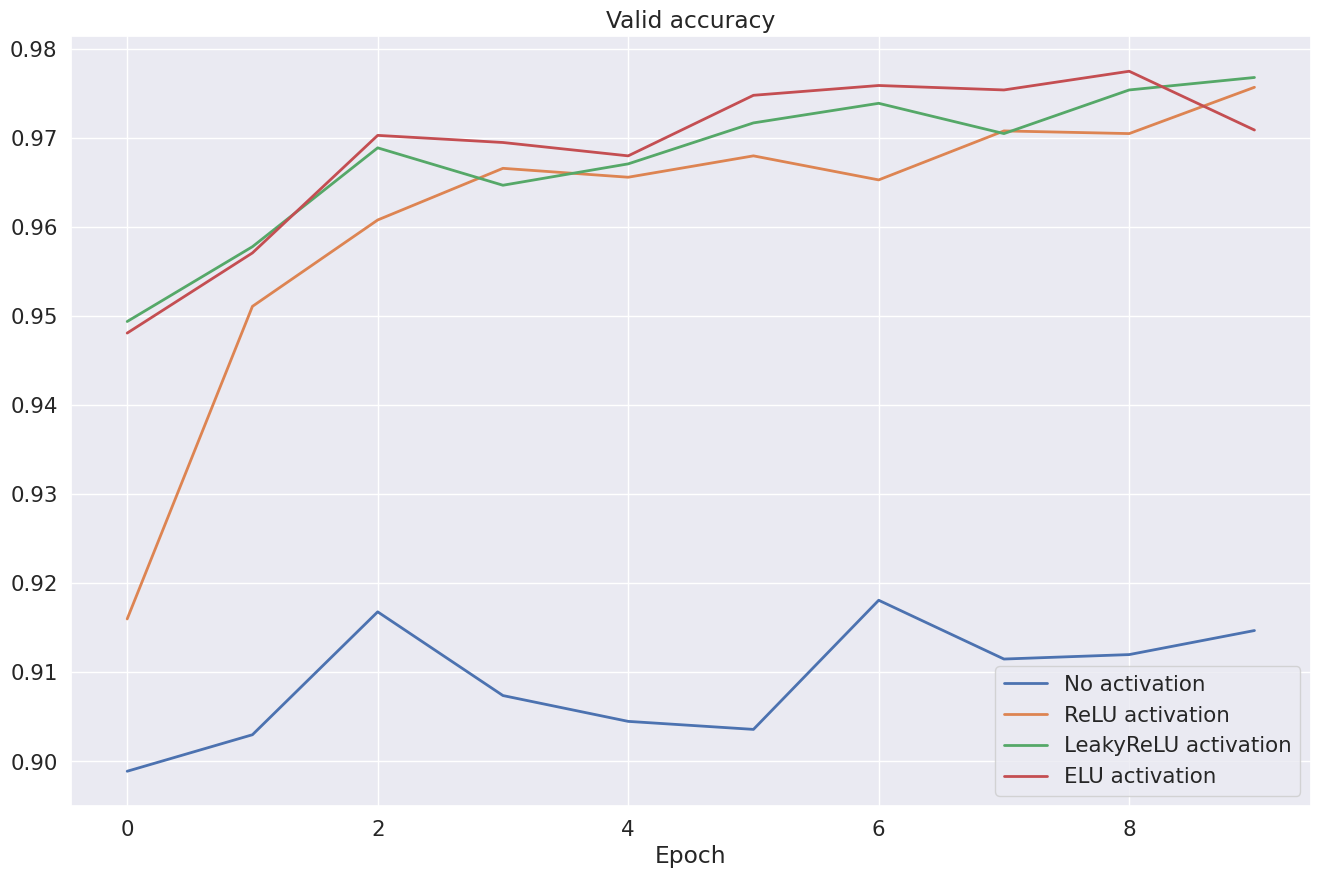

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

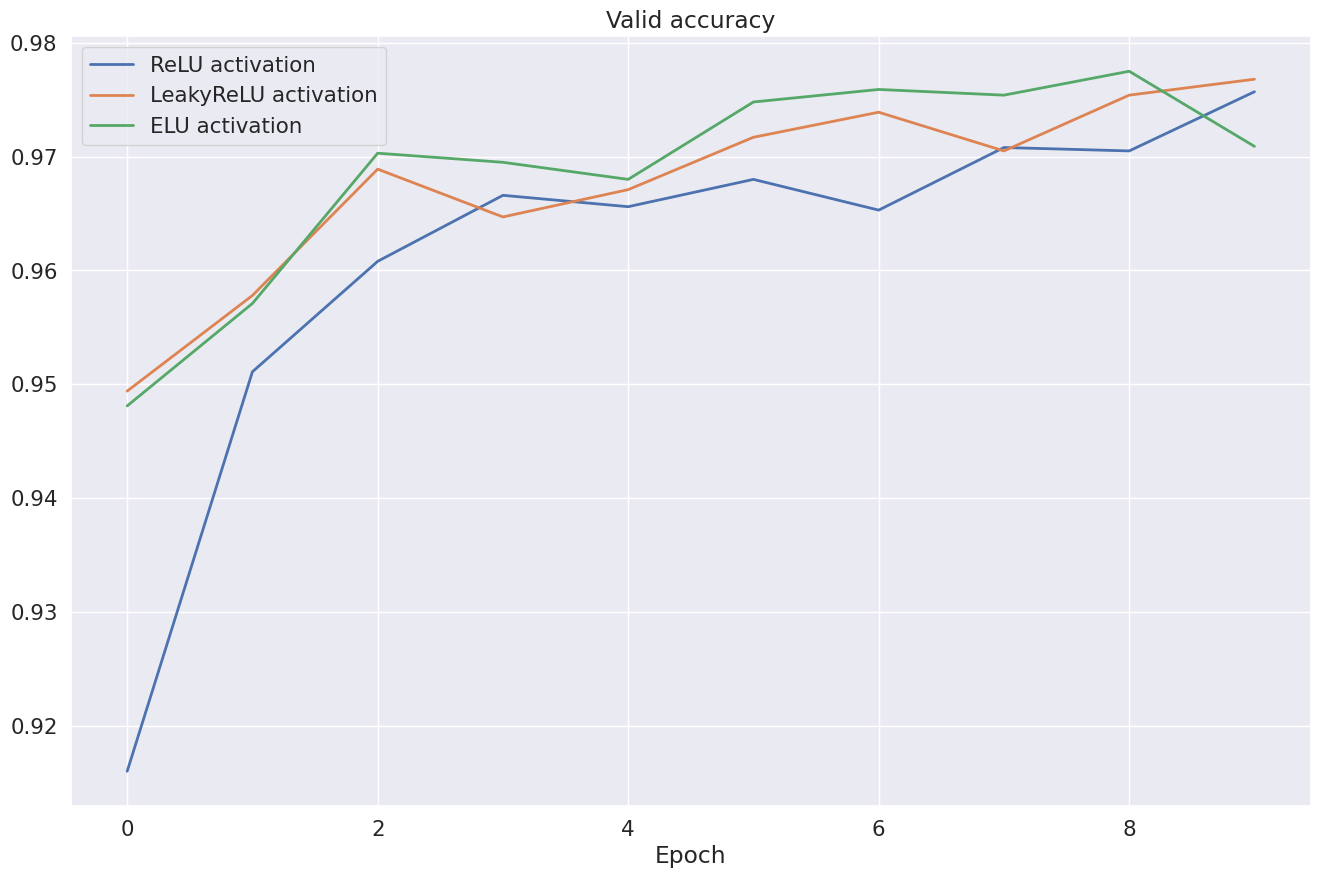

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [ ]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2024-07-07 20:45:11--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   159KB/s    in 0.3s    

2024-07-07 20:45:12 (159 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



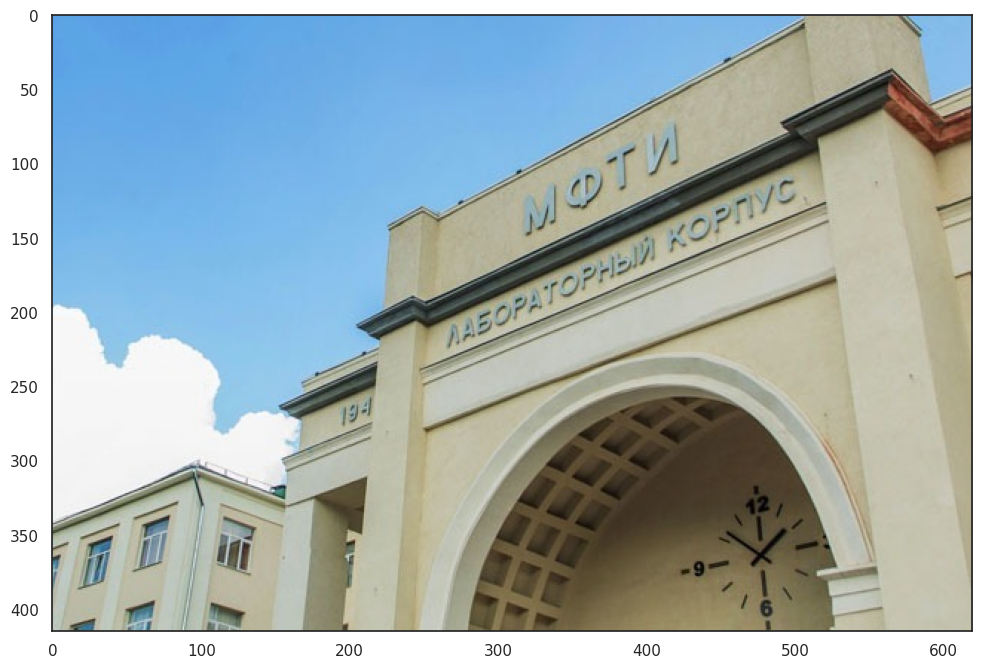

In [ ]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [ ]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]

]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

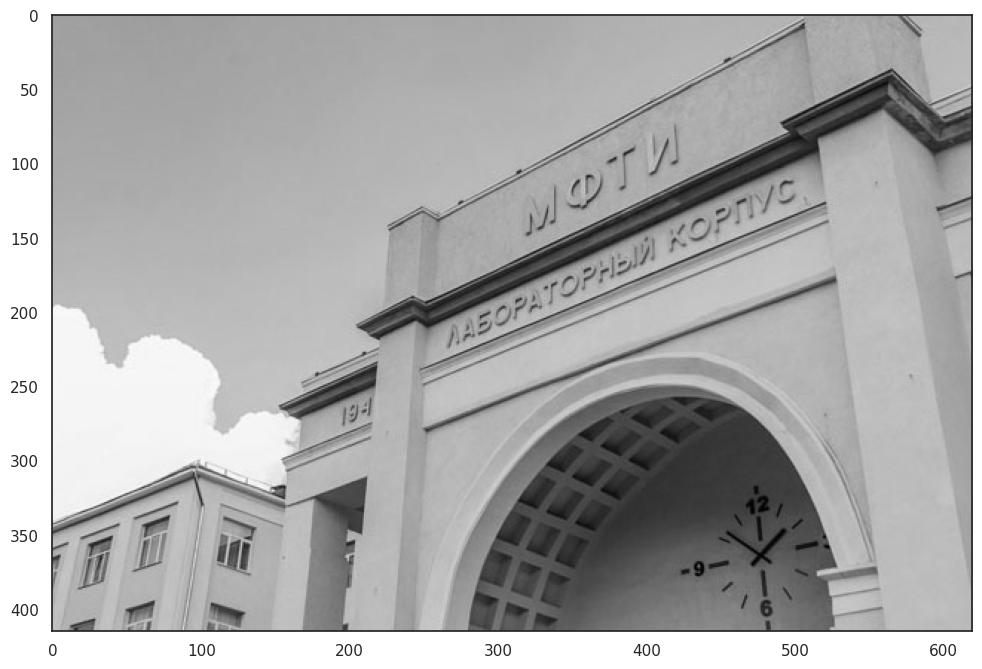

In [ ]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие e

2) Увеличение резкости д

3) Тождественное преобразование а

4) Выделение вертикальных границ в

5) Выделение горизонтальных границ б

6) Выделение границ г

**Ответ:** едавбг

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [ ]:

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # Сверточный слой 1: 1 входной канал, 6 выходных каналов, ядро 3x3
        self.conv1 = nn.Conv2d(1, 6, 3)
        # Максимальный пуллинг с ядром 2x2
        self.pool1 = nn.MaxPool2d(2, 2)
        # Сверточный слой 2: 6 входных каналов, 16 выходных каналов, ядро 3x3
        self.conv2 = nn.Conv2d(6, 16, 3)
        # Максимальный пуллинг с ядром 2x2
        self.pool2 = nn.MaxPool2d(2, 2)
        # Полносвязный слой 1: 16 * 6 * 6 входов, 120 выходов (предполагаем размер входного изображения 32x32)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        # Полносвязный слой 2: 120 входов, 84 выхода
        self.fc2 = nn.Linear(120, 84)
        # Выходной слой: 84 входа, 10 выходов
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Применяем свертку, затем ReLU, затем максимальный пуллинг
        x = self.pool1(F.relu(self.conv1(x)))
        # Применяем свертку, затем ReLU, затем максимальный пуллинг
        x = self.pool2(F.relu(self.conv2(x)))
        # Уплощаем все измерения, кроме батча
        x = torch.flatten(x, 1)
        # Применяем полносвязный слой, затем ReLU
        x = F.relu(self.fc1(x))
        # Применяем полносвязный слой, затем ReLU
        x = F.relu(self.fc2(x))
        # Применяем выходной слой
        x = self.fc3(x)
        return x

In [ ]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN


In [ ]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

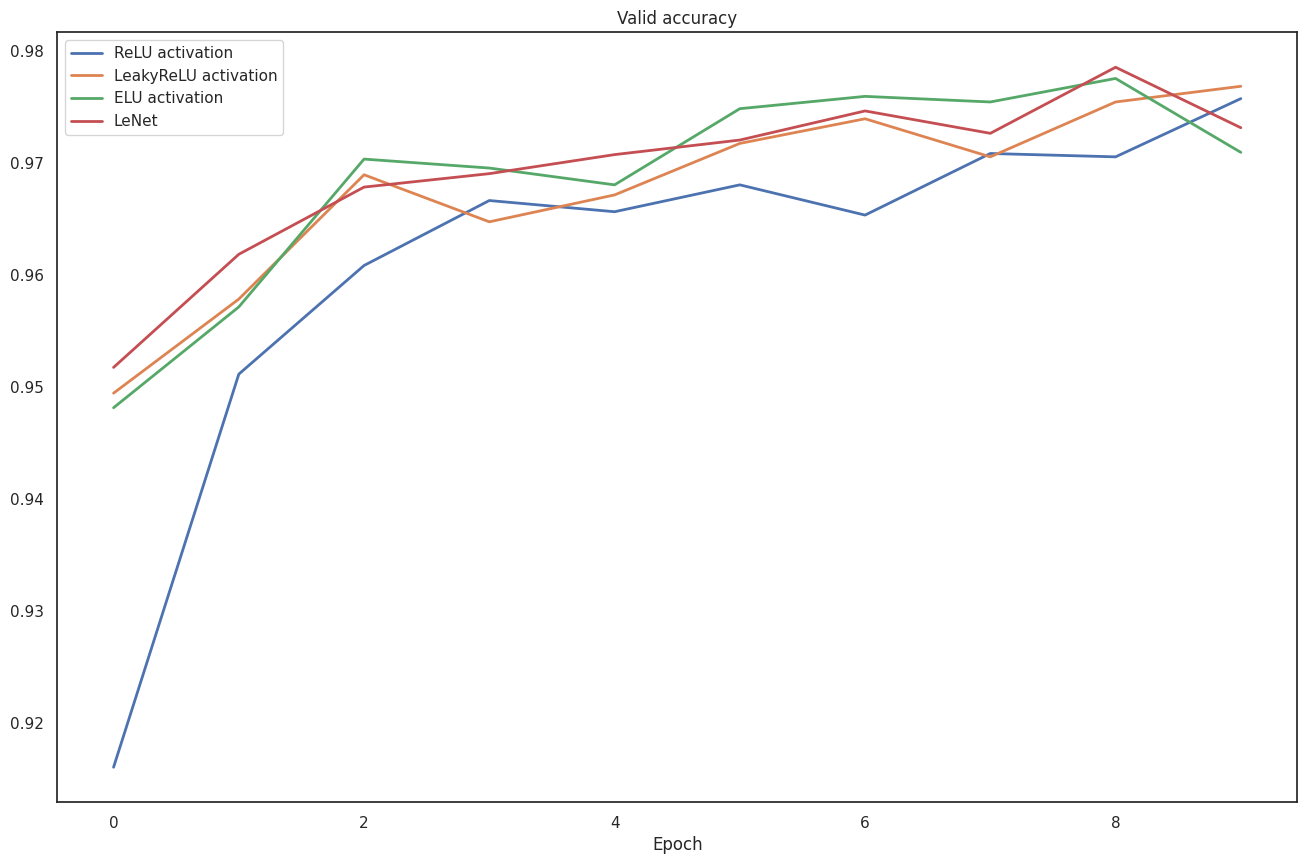

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [ ]:
lenet_accuracy

[0.9517, 0.9618, 0.9678, 0.969, 0.9707, 0.972, 0.9746, 0.9726, 0.9785, 0.9731]

In [ ]:
elu_accuracy

[0.9481, 0.9571, 0.9703, 0.9695, 0.968, 0.9748, 0.9759, 0.9754, 0.9775, 0.9709]

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**0.97 lenet